# Tutorial - Trace-based Attacks

This tutorial covers:
    
- A summary DCA-style (trace-based) attacks
- How to run them using provided basic implementations

## Basic Framework
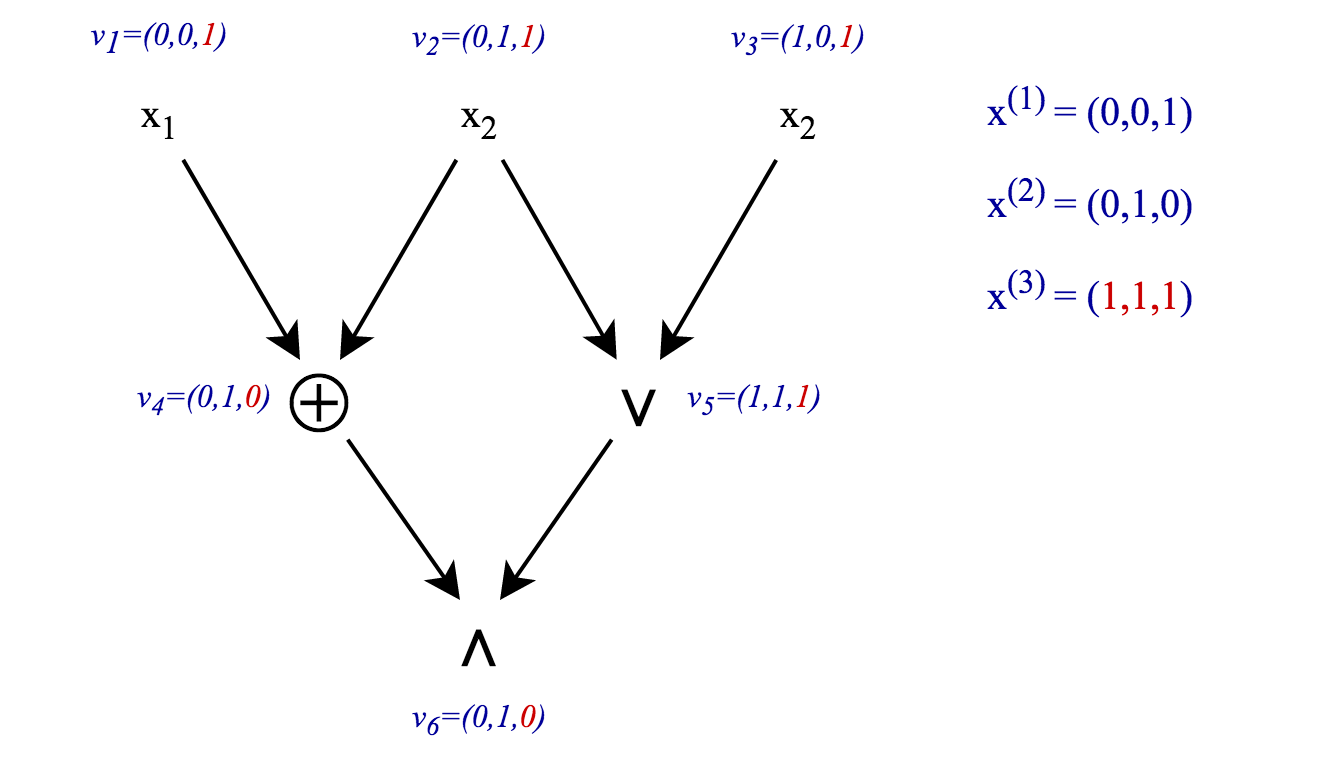

We consider $T$ traces of $N$ functions (on the example, $T=3$, $N=6$).
They are arranged in a **matrix** $V$, each *row* corresponding to one *trace*, and each *column* corresponding to one computed *function* (across all $T$ inputs):

$$V = \pmatrix{v_1 &|& v_2 &|& v_3 &|& \ldots &|& v_N}$$

We target the 1st round of the AES block cipher. More concretely, we focus on *"finding"* an output bit of a chosen S-box $S(x_i \oplus k_i)$ in the white-box implementation. Here, "bit" means "a function" of the input $x$. As this function also depends on the subkey byte $k_i$, we will consider all possible values of this byte.

*"Finding"* means different things in the three attacks we consider: exact matching, correlation (DCA) and linear algebraic attack (LDA).

**Remark**: instead of considering one of the 8 direct output bits, it is also beneficial to consider all/some of their 255 linear (XOR) combinations.

## Exact Matching Attack

The exact matching attack simply attempts to match the guessed function **precisely** on **all** considered inputs. Thus, it can only break an unprotected or implementation.

It can be implemented very efficiently:
1. Evaluate all guessed functions and put them in a hash-set: $D = \{s_k\}_k$
2. For each $v_i$ (a column of $V$), check if it is in the set $D$.

Time: $O(T(K+N))$

```sh
$ pypy3 attacks/analyze_exact.py -h
usage: analyze_exact.py [-h] [-T N_TRACES] [-w WINDOW] [--step STEP] [--masks MASKS] [-o ORDER] trace_dir

Apply "Exact Matching Attack" on pre-recorder traces.

positional arguments:
  trace_dir             path to directory with trace/plaintext/ciphertext files

optional arguments:
  -h, --help            show this help message and exit
  -T N_TRACES, --n-traces N_TRACES
                        number of traces to use in the attack (default: 100)
  -w WINDOW, --window WINDOW
                        sliding window size (default: 2048)
  --step STEP           sliding window step (default: 1024)
  --masks MASKS         linear masks to consider (comma separated ints, or 'all', or 'random16', 'random32') (default: 1,2,4,8,16,32,64,128)
  -o ORDER, --order ORDER
                        attack order (1 or 2) (default: 1)
```

```sh
$ pypy3 attacks/analyze_exact.py tutorials/traces/aes10_clear/
Total traces: 100 of size 3.9K bits (3894)
Using linear masks: (1, 2, 4, 8, 16, 32, 64, 128)
Generated 65536 target vectors
Window 1 / 30
offset 0-2048 (of 31152)
    2048 vectors
    2035 unique vectors
    65536 target vectors
MATCH (SINGLE):
sbox #0,
lin.mask 0x01,
key 0x61='a',
negated? False,
indexes (1 total) [202]

...

Matches (by position): [1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2]
Key candidates found:
S-Box #0: 0x61('a')
S-Box #1: 0x62('b')
S-Box #2: 0x63('c')
S-Box #3: 0x64('d')
S-Box #4: 0x65('e')
S-Box #5: 0x66('f')
S-Box #6: 0x67('g')
S-Box #7: 0x68('h')
S-Box #8: 0x41('A')
S-Box #9: 0x42('B')
S-Box #10: 0x43('C')
S-Box #11: 0x44('D')
S-Box #12: 0x45('E')
S-Box #13: 0x46('F')
S-Box #14: 0x47('G')
S-Box #15: 0x48('H')

Example: 61626364656667684142434445464748
```

## Exact Matching Attack (Second-Order)
The attack can be generalized to break low-order linear masking:
$$s = v_i \oplus v_j ~~\Leftrightarrow~~ s \oplus v_i = v_j.$$

1. Put the trace columns $v_j$ in the hash-set $D = V$.
2. For each guessed function $s_k$ and each trace column $v_i$, check if $s_k \oplus v_i$ is in $D$.

Time: $O(T(KN))$

```sh
pypy3 attacks/analyze_exact.py tutorials/traces/aes2_isw2/ -o 2 -w 1000000 -s 1000000 --masks 1
```

## Correlation Attack (DCA - Differential Computation Analysis)



Correlation attacks relaxes the requirement to **partial** matching. More precisely, the procedure is roughly:

- for each trace vector $v_i \in V$ (a computed function)
  - for each $s_k$ (a guessed function)
    - compute a correlation $v_i \otimes s_k$

A sufficiently high correlation witnesses a likely correct guessed function.

In [ ]:
run

## Linear Algebraic Attack (LDA - Linear Decoding Analysis)


Recall that traces are arranged in the matrix
$$V = \pmatrix{v_1 &|& v_2 &|& v_3 &|& \ldots &|& v_N}$$

The aim of LDA is to find any amount of intermediate functions that **sum** (XOR) to a given gussed function. This amounts to simply solving the matrix equation
$$V \times z = \pmatrix{s_k(x_1)\\s_k(x_2)\\\vdots\\s_k(x_T)\\}$$

(This has to be done for every guessed function $s_k$, but this can be batched by a precomputation on the matrix $V$)

**Important**: it requires a number of traces $T \ge N + \varepsilon$ for a small integer $\varepsilon$ to avoid false-positives.

In [ ]:
run

## Conclusions

1. Exact matching attack: very effective against unprotected / low-order masked impl.
2. Correlation attack: can break nonlinear masking with 1 linear share, (dummy) shuffling.
3. Algebraic attack: can break linear masking with **any number** of shares.